# Table des matières

### [Importations](#T1)
- [Importing packages](#T1C1)
- [Importing missing data](#T1C2)
  
### [Feature engineering](#T2)
- [Eliminating no null data](#T2C1)
- [Feature engineering](#T2C2)

### [Tracking](#T3)
- [Measures](#T3C1)
- [Mlflow](#T3C2)

### [Machine learning](#T4)
- [Variable transformation](#T4C1)
- [Data splitting](#T4C2)
- [Pipeline](#T4C3)
- [Algorithmes](#T4C4)
- [Results](T#4C5)

### Goal:

We have a lot of missing data on fibers and nutriscore value.

We don't know if those data are missing from the database (not enter by user), were not measure by vendor.

At least, the nutriscore will be needed.

Depending of the results obtained with the models developed, we could present different outcomes for the data:

- Nutriscore value
- Nutriscore window
- Nutriscore letter window
- Fiber
- Fiber window

***
# <a name="T1">Importations</a>

### <a name = "T1C1">a. Importing packages</a>

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import mlflow
import time

from mlflow.sklearn import log_model, save_model, autolog

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.linear_model import LinearRegression

### <a name = "T1C2">b. Importing missing data</a>

In [39]:
# Get the current directory of the notebook
file_dir = os.getcwd()
app_dir = os.path.dirname(file_dir)

# Define the path to the file in the /files directory
file_path = os.path.join(app_dir, 'files', 'missing_data.csv')

# Now you can use the file_path to access your file
with open(file_path, 'r') as file:
    data = pd.read_csv(file_path, sep = "\t")

C:\Users\33664\AppData\Local\Temp\ipykernel_2320\3914342728.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep = "\t")


In [40]:
data

,code,product_name,countries_en,nutriscore_score,pnns_groups_1,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g,macronutrients_100g
0,00000000000026772226,Skyr,France,-5.0,Milk and dairy products,Dairy desserts,57.000000,238.0,0.200000,0.10000,3.90,NaN,10.0,0.09,14.190000
1,0000000000017,Vitória crackers,France,NaN,unknown,unknown,375.000000,1569.0,7.000000,3.08000,70.10,NaN,7.8,1.40,86.300000
2,000000000004622327,Hamburguesas de ternera 100%,Spain,NaN,unknown,unknown,874.900000,3661.0,15.100000,6.10000,2.60,NaN,15.7,2.10,35.500000
3,000000000006021,Blueberry Cobbler Coffee,United States,NaN,unknown,unknown,0.000000,0.0,0.000000,0.00000,0.00,0.0,0.0,0.00,0.000000
4,0000000000123,Sauce Sweety chili 0%,France,NaN,unknown,unknown,21.000000,88.0,0.000000,0.00000,4.80,NaN,0.2,2.04,7.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296964,5060650730097,The Orginal sweet bread,France,4.0,Cereals and potatoes,Bread,328.000000,1400.0,2.100000,0.60000,73.40,NaN,9.1,0.69,85.290000
1296965,5060650960128,black truffle ketchup,United States,6.0,Fat and sauces,Dressings and sauces,133.333333,558.0,5.000000,0.00000,20.00,NaN,0.0,1.25,26.250000
1296966,5060650960135,Black Truffle Mustard,United States,13.0,Fat and sauces,Dressings and sauces,300.000000,1260.0,30.000000,0.00000,0.00,0.0,0.0,4.00,34.000000
1296967,5060650960173,Huile de truffe (Trüffel-Öl),"France,Germany",NaN,unknown,unknown,801.000000,3293.0,88.500000,12.40000,1.17,NaN,0.0,0.02,89.690000


***
# <a name="T2">Feature engineering</a>

### <a name = "T2C1">a. Eliminating no null data</a>

Some data don't have any macronutrients informations, we will discard them

In [41]:
print("We going from %d rows" %data.shape[0], end = " ")
data = data.loc[data.macronutrients_100g != 0]
print("to %d rows after clean-up " %data.shape[0])

We going from 1296969 rows to 1278321 rows after clean-up 


We will eliminate data where the fiber count is > to carbohydrate count


In [42]:
print("We going from %d rows" %data.shape[0], end = " ")
data = data.loc[(data.fiber_100g <= data.carbohydrates_100g) | (data.fiber_100g.isna())]
print("to %d rows after clean-up " %data.shape[0])

We going from 1278321 rows to 1263531 rows after clean-up 


In [43]:
print("We going from %d rows" %data.shape[0], end = " ")
data = data.loc[data.fat_100g >= data["saturated-fat_100g"]]
print("to %d rows after clean-up " %data.shape[0])

We going from 1263531 rows to 1262854 rows after clean-up 


### <a name = "T2C2">b. Feature engineering</a>

We will add some features, it could help with the modelisation

In [185]:
def ratio_calcul(df, ratio_col, nutrient1, nutrient2):

    # Calculate the ratio
    df[ratio_col] = df[nutrient1] / df[nutrient2]
    
    # Check for np.inf and replace with the maximum non-infinite value
    df.loc[df[ratio_col] == np.inf, ratio_col] = df[df[ratio_col] == np.inf].apply(lambda x: x[nutrient1] 
                                                if x[nutrient1] > x[nutrient2] 
                                                else x[nutrient2], axis = 1)
    
    # Replace Nan value with 0
    df[ratio_col] = df[ratio_col].fillna(0)
    
    return df

In [186]:
data = ratio_calcul(data, "ratio_carbs_proteins", "carbohydrates_100g", "proteins_100g")
data = ratio_calcul(data, "ratio_carbs_fats", "carbohydrates_100g", "fat_100g")
data = ratio_calcul(data, "ratio_carbs_sat_fat", "carbohydrates_100g", "saturated-fat_100g")
data = ratio_calcul(data, "ratio_carbs_salt", "carbohydrates_100g", "salt_100g")
data = ratio_calcul(data, "ratio_carbs_fiber", "carbohydrates_100g", "fiber_100g")
data = ratio_calcul(data, "ratio_carbs_total", "carbohydrates_100g", "macronutrients_100g")

data = ratio_calcul(data, "ratio_prots_fats", "proteins_100g", "fat_100g")
data = ratio_calcul(data, "ratio_prots_sat_fats", "proteins_100g", "saturated-fat_100g")
data = ratio_calcul(data, "ratio_prots_fiber", "proteins_100g", "fiber_100g")
data = ratio_calcul(data, "ratio_prots_salt", "proteins_100g", "salt_100g")
data = ratio_calcul(data, "ratio_prots_total", "proteins_100g", "macronutrients_100g")

data = ratio_calcul(data, "ratio_fats_sat_fats", "fat_100g", "saturated-fat_100g")
data = ratio_calcul(data, "ratio_fats_salt", "fat_100g", "salt_100g")
data = ratio_calcul(data, "ratio_fats_fiber", "fat_100g", "fiber_100g")
data = ratio_calcul(data, "ratio_fats_total", "fat_100g", "macronutrients_100g")

data = ratio_calcul(data, "ratio_salt_fiber", "salt_100g", "fiber_100g")
data = ratio_calcul(data, "ratio_salt_sat_fats", "salt_100g", "saturated-fat_100g")
data = ratio_calcul(data, "ratio_salt_total", "salt_100g", "macronutrients_100g")

data = ratio_calcul(data, "ratio_fibers_sat_fats", "fiber_100g", "saturated-fat_100g")
data = ratio_calcul(data, "ratio_fibers_total", "fiber_100g", "macronutrients_100g")

data = ratio_calcul(data, "ratio_sat_fats_total", "saturated-fat_100g", "macronutrients_100g")


In [141]:
data.columns

Index(['code', 'product_name', 'countries_en', 'nutriscore_score',
       'pnns_groups_1', 'pnns_groups_2', 'energy-kcal_100g', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'macronutrients_100g',
       'ratio_carbs_proteins', 'ratio_carbs_fats', 'ratio_carbs_sat_fat',
       'ratio_carbs_salt', 'ratio_carbs_fiber', 'ratio_carbs_total',
       'ratio_prots_fats', 'ratio_prots_sat_fats', 'ratio_prots_fiber',
       'ratio_prots_salt', 'ratio_prots_total', 'ratio_fats_sat_fats',
       'ratio_fats_salt', 'ratio_fats_fiber', 'ratio_fats_total',
       'ratio_salt_fiber', 'ratio_salt_sat_fats', 'ratio_salt_total',
       'ratio_fibers_sat_fats', 'ratio_fibers_total', 'ratio_sat_fats_total'],
      dtype='object')

***
# <a name="T3">Tracking</a>

### <a name = "T3C1">a. Measures</a>

We will follow classical metrics: 
Numeric ones:
- R²
- Overfiting
- RMSE: np.sqrt(mean_squared_error(y_test, y_result))) 
- Performance scorer: (1 - (sum(abs(y_result - ytest))/sum(y_test))) * 100

Graphical ones:
- Residual

In [248]:
def my_custom_score_func(y_result, y_test):
    ##
    # Returning a score between 0 and 100
    # Closer to 100 for a better prediction
    ##
    return (1 - (sum(abs(y_result - y_test))/sum(y_test))) * 100


In [249]:
# We create the scorer
my_scorer = make_scorer(my_custom_score_func, greater_is_better=True)

In [273]:
def plotResiduals_prediction(model_name, ytrain, ytest, ytrain_pred, y_result):
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(ytrain_pred, ytrain_pred - ytrain, c = "blue", marker = "s", label = "Training data")
    ax1.scatter(y_result, y_result - ytest, c = "lightgreen", marker = "s", label = "Testing data")
    
    ax2.violinplot([ytrain_pred - ytrain, y_result - ytest], showextrema = False)

    fig.suptitle(model_name)

    ax1.set_title("Scatter plot of residual values")
    ax2.set_title("Violon plot of residual values")

    ax1.set(xlabel='Predicted values', ylabel='Residual values')
    ax2.set(xlabel='', ylabel='Residual valeus')

    ax2.set_xticklabels("")

    ax1.plot(np.linspace(0,100,1), np.linspace(0,100,1), c = 'orange', linestyle='--')

    ax1.legend(loc = "lower right")
    ax2.legend(loc = "lower right")
    
    pos = [1, 2]
    label = ["Training data", "Testing data"]
    
    ax2.set_xticks(pos)
    ax2.set_xticklabels(label)

    ax1.set_xlim(0, 100)
    ax1.set_ylim(-100, 100)
    ax2.set_ylim(-100, 100)
    
    fig.tight_layout()
    plt.show()

    # Predicted values
    
    plt.figure(figsize=(12,6))
    plt.scatter(ytrain_pred, ytrain, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_result, ytest, c = "lightgreen", marker = "s", label = "Testing data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.legend(loc = "upper left")
    plt.plot(np.linspace(0,100,1), np.linspace(0,100,1), c = 'orange', linestyle='--')
    plt.tight_layout()
    plt.show()

### <a name = "T3C2">b. Mlflow</a>

We would like to develop a full MLops pipeline to ensure that the model developed is up-to-date with new features.

We will use mlflow to follow the model developement, metrics.

In [52]:
def log_mlflow(hyperparam_grid, dict_scores, best_parameters):
    ##
    #    Function keep tract of hyperparameters tested and the metrics
    # to add: figures
    ##
    
    # Log grid_search tests
    mlflow.log_params(hyperparam_grid)    
    
    # Log best hyperparams
    mlflow.log_params({"best_" + key: value for key, value in best_parameters.items()})
    
    # Log metrics
    for key, value in dict_scores.items():
        mlflow.log_metric(str(key), value)

***
# <a name="T4">Machine learning</a>

### <a name = "T4C1">a. Variable transformation</a>

We have to take into account the PNNS_groups 1 and 2: 

So we will have to encode them. 

For the numeric values, we will maybe do an log transformation.

In [218]:
numeric_features = list(data.dtypes[data.dtypes == "float64"].index)
numeric_features

['nutriscore_score',
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'macronutrients_100g',
 'ratio_carbs_proteins',
 'ratio_carbs_fats',
 'ratio_carbs_sat_fat',
 'ratio_carbs_salt',
 'ratio_carbs_fiber',
 'ratio_carbs_total',
 'ratio_prots_fats',
 'ratio_prots_sat_fats',
 'ratio_prots_fiber',
 'ratio_prots_salt',
 'ratio_prots_total',
 'ratio_fats_sat_fats',
 'ratio_fats_salt',
 'ratio_fats_fiber',
 'ratio_fats_total',
 'ratio_salt_fiber',
 'ratio_salt_sat_fats',
 'ratio_salt_total',
 'ratio_fibers_sat_fats',
 'ratio_fibers_total',
 'ratio_sat_fats_total']

In [85]:
categorical_feature = ["pnns_groups_1", "pnns_groups_2"]

In [79]:
"""for col in numeric_feature:
    print("%s: %.2f" %(col, data[col].skew()))"""

'for col in numeric_feature:\n    print("%s: %.2f" %(col, data[col].skew()))'

In [75]:
enc_pnns1 = OneHotEncoder(handle_unknown='ignore')
enc_pnns1.fit(data[['pnns_groups_1']])
print(enc_pnns1.categories_)
enc_pnns1.transform(data[['pnns_groups_1']]).toarray()

[array(['Alcoholic beverages', 'Beverages', 'Cereals and potatoes',
       'Composite foods', 'Fat and sauces', 'Fish Meat Eggs',
       'Fruits and vegetables', 'Milk and dairy products', 'Salty snacks',
       'Sugary snacks', 'unknown'], dtype=object)]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [74]:
enc_pnns2 = OneHotEncoder(handle_unknown='ignore')
enc_pnns2.fit(data[['pnns_groups_2']])
print(enc_pnns2.categories_)
enc_pnns2.transform(data[['pnns_groups_2']]).toarray()

[array(['Alcoholic beverages', 'Appetizers',
       'Artificially sweetened beverages', 'Biscuits and cakes', 'Bread',
       'Breakfast cereals', 'Cereals', 'Cheese', 'Chocolate products',
       'Dairy desserts', 'Dressings and sauces', 'Dried fruits', 'Eggs',
       'Fats', 'Fish and seafood', 'Fruit juices', 'Fruit nectars',
       'Fruits', 'Ice cream', 'Legumes', 'Meat', 'Milk and yogurt',
       'Nuts', 'Offals', 'One-dish meals', 'Pastries',
       'Pizza pies and quiches', 'Plant-based milk substitutes',
       'Potatoes', 'Processed meat', 'Salty and fatty products',
       'Sandwiches', 'Soups', 'Sweetened beverages', 'Sweets',
       'Teas and herbal teas and coffees', 'Unsweetened beverages',
       'Vegetables', 'Waters and flavored waters', 'unknown'],
      dtype=object)]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### <a name = "T4C2"> b. Data splitting</a>

We won't select the products without a valid pnns_groups, as we suggest that pnns_grouping would help in predicting missing values

We also won't select data with missing values

In [188]:
mask = data[(data["pnns_groups_1"] != 'unknown') & (data["pnns_groups_2"] != 'unknown')].copy()
mask = mask[(~mask["fiber_100g"].isna()) & (~mask["nutriscore_score"].isna())].copy()

In [189]:
mask.shape

(313718, 36)

We need to confirm the clean-up

In [145]:
mask.pnns_groups_1.unique()

array(['Composite foods', 'Fruits and vegetables', 'Cereals and potatoes',
       'Sugary snacks', 'Fat and sauces', 'Beverages', 'Fish Meat Eggs',
       'Salty snacks', 'Milk and dairy products', 'Alcoholic beverages'],
      dtype=object)

In [146]:
mask.pnns_groups_2.unique()

array(['Pizza pies and quiches', 'Fruits', 'Bread', 'Vegetables',
       'Pastries', 'Dressings and sauces', 'Sweetened beverages',
       'Sweets', 'Biscuits and cakes', 'Dried fruits',
       'Breakfast cereals', 'Fish and seafood', 'One-dish meals',
       'Appetizers', 'Salty and fatty products', 'Cheese', 'Fats',
       'Processed meat', 'Sandwiches', 'Chocolate products',
       'Unsweetened beverages', 'Meat', 'Cereals', 'Eggs',
       'Plant-based milk substitutes', 'Legumes',
       'Teas and herbal teas and coffees', 'Dairy desserts', 'Nuts',
       'Fruit juices', 'Milk and yogurt',
       'Artificially sweetened beverages', 'Potatoes', 'Soups',
       'Ice cream', 'Offals', 'Waters and flavored waters',
       'Fruit nectars', 'Alcoholic beverages'], dtype=object)

In [200]:
# To predict fibers, we eliminate fibers from the dataset
fibers_drop = list([col for col in data.columns if "fiber" in col])
X_to_fibers = mask[numeric_feature + categorical_feature].drop(fibers_drop, axis = 1)
Y_to_fibers = mask["fiber_100g"]

In [236]:
numeric_features_to_fibers = [col for col in numeric_features if "fiber" not in col]

In [201]:
# We stratify with pnns_groups_2, to be sure of the proportion
xtrain, xtest, ytrain, ytest = train_test_split(X_to_fibers, 
                                                Y_to_fibers, 
                                                test_size = 0.2, 
                                                stratify = X_to_fibers["pnns_groups_2"], 
                                                random_state = 42)

In [202]:
print("Shape of training data:", xtrain.shape)
print("Shape of testing data:", xtest.shape)

Shape of training data: (250974, 26)
Shape of testing data: (62744, 26)


In [207]:
xtrain.value_counts("pnns_groups_1")

pnns_groups_1
Sugary snacks              52996
Cereals and potatoes       41722
Milk and dairy products    30065
Fish Meat Eggs             25658
Composite foods            25237
Fat and sauces             24714
Fruits and vegetables      23482
Beverages                  16242
Salty snacks               10848
Alcoholic beverages           10
Name: count, dtype: int64

In [208]:
xtest.value_counts("pnns_groups_1")

pnns_groups_1
Sugary snacks              13249
Cereals and potatoes       10431
Milk and dairy products     7516
Fish Meat Eggs              6415
Composite foods             6310
Fat and sauces              6179
Fruits and vegetables       5870
Beverages                   4060
Salty snacks                2712
Alcoholic beverages            2
Name: count, dtype: int64

In [205]:
xtrain.value_counts("pnns_groups_2")

pnns_groups_2
Biscuits and cakes                  27861
Sweets                              20568
Dressings and sauces                20077
Cereals                             19137
One-dish meals                      18543
Cheese                              14224
Vegetables                          13565
Bread                               11561
Milk and yogurt                     11013
Processed meat                       9218
Fish and seafood                     7650
Meat                                 7545
Fruits                               6870
Appetizers                           6320
Breakfast cereals                    5762
Sweetened beverages                  4805
Pizza pies and quiches               4659
Fats                                 4637
Legumes                              4234
Unsweetened beverages                3571
Chocolate products                   3365
Ice cream                            2763
Plant-based milk substitutes         2546
Nuts                

In [206]:
xtest.value_counts("pnns_groups_2")

pnns_groups_2
Biscuits and cakes                  6966
Sweets                              5142
Dressings and sauces                5020
Cereals                             4785
One-dish meals                      4636
Cheese                              3556
Vegetables                          3391
Bread                               2891
Milk and yogurt                     2753
Processed meat                      2305
Fish and seafood                    1912
Meat                                1886
Fruits                              1717
Appetizers                          1580
Breakfast cereals                   1440
Sweetened beverages                 1201
Pizza pies and quiches              1165
Fats                                1159
Legumes                             1058
Unsweetened beverages                893
Chocolate products                   841
Ice cream                            691
Plant-based milk substitutes         636
Nuts                                 635
Fr

We confirm the good stratification.

### <a name = "T4C3">c. Pipeline</a>

In [308]:
def search_best_model(model_name, model, categorical_feature, numeric_features, hyperparams, x_train, y_train, x_test, y_test, model_type = None):

    # For scaling and encoding
    columnT = ColumnTransformer(
    transformers = [
                   # ('log_transformer', FunctionTransformer(log1p_transformer), numeric_features),
                   ('scaler', None, numeric_features),
                   ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_feature),
                   ],

    remainder = "passthrough",
    n_jobs = -1)

    # Pipeline
    pipe = Pipeline([
        ('transformation', columnT),
        ('model', model)
    ])

    # To conserve the result
    scores = {}

    # To measure fiting
    timing = time.time()
 
    # For classification
    #stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # For linear regression
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    

    # On réalise un GridSearchCV pour trouver les meilleurs hyperparamètres pour les modèles de type non "arbre de décision"
    print("%d hyperparameters are tested" %hyperparams_number(hyperparams))#%calcul_nombre_hyperparametres(params)) 

    grid = GridSearchCV(pipe, 
                        hyperparams, 
                        cv = kfold,
                        scoring = my_scorer,
                        verbose = 3)


    # Fiting on train data
    grid.fit(x_train, y_train)

    elapsed_time = time.time()

    # We measure the mean timing
    scores["mean_training_time"] = round((elapsed_time - timing) / hyperparams_number(hyperparams) , 1)

    # Best parameters 
    best_params = grid.best_estimator_

    # Cross evaluation
    cross_scores = cross_val_score(best_params, x_train, y_train, cv=kfold, scoring=my_scorer)
    print("Mean score: %0.2f with an STD:  %0.2f \n" 
              % (cross_scores.mean(), cross_scores.std()))

    # We visualize the results
    plotResiduals_prediction(model_name, y_train, y_test, grid.predict(x_train), grid.predict(x_test))

In [241]:
def hyperparams_number(param_grid):
    ##
    #    return the number of hyperparams tested
    ##
    
    # initialisation
    total = 1
    
    for values in param_grid.values():
        total *= len(values)

    # Returning the number
    return total

In [ ]:
def search_model_params_score_metier(model_name, model, categoric_features, numeric_features, hyperparams, x_train, y_train, x_test, y_test, model_type = None):

    # For scaling and encoding
    columnT = ColumnTransformer(
    transformers = [
                   ('scaler', None, numeric_features),
                   ('ohe', OneHotEncoder(handle_unknown='ignore'), categoric_features),
                   ],

    remainder = "passthrough",
    n_jobs = -1)

    # Pipeline
    pipe = Pipeline([
        ('transformation', columnT),
        ('model', model)
    ])

    # To conserve the result
    scores = {}

    # To measure fiting
    timing = time.time()

    # For classification
    #stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # For linear regression
    KFold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # On réalise un GridSearchCV pour trouver les meilleurs hyperparamètres pour les modèles de type non "arbre de décision"
    print("%d hyperparameters are tested" %len(hyperparams))#%calcul_nombre_hyperparametres(params)) 

    grid = GridSearchCV(pipe, 
                        hyperparams, 
                        cv = KFold,
                        scoring = my_scorer, 
                        verbose = 1)


    # Fiting on train data
    grid.fit(x_train, y_train)

    elapsed_time = time.time()

    # We measure the mean timing
    scores["mean_training_time"] = round((elapsed_time - timing) / len(hyperparams) , 1)

    # Best parameters 
    best_params = grid.best_estimator_

    # Cross evaluation
    cross_scores = cross_val_score(best_params, x_train, y_train, cv=KFold, scoring=my_scorer)
    print("Mean score: %0.2f with an STD:  %0.2f \n" 
              % (cross_scores.mean(), cross_scores.std()))

    # On mesure les différentes métriques et on ajoute au dictionnaire
    scores.update(calcul_scores(best_param_pipe, x_train, y_train, x_test, y_test, beta, my_func = my_custom_scoring))

    # On mesure le temps d'application du meilleur modèle
    scores["elapsed_time"] = round(time.time() - time1, 1)

    # On affiche les différents résultats des métriques
    affichage_score(grid.best_params_, scores)

    new_scores = {"training_time" : scores["training_time"],
                 "elapsed_time" : scores["elapsed_time"]}
    
    # On mesure les nouveaux scores obtenus avec le meilleur seuil
    new_scores.update(calcul_scores(best_param_pipe, 
                                    x_train, 
                                    y_train,
                                    x_test, 
                                    y_test, 
                                    beta, 
                                    meilleur_seuil, 
                                    my_func = my_custom_scoring))

    print("Affichages nouveaux scores avec le meilleur seuil")

    # On affiche les différents résultats des métriques
    affichage_score(grid.best_params_, new_scores)
    
    # on ajoute le score de seuil au modèle
    new_scores["Valeur seuil"] = meilleur_seuil
    
    # Nous réalisons la prédiction avec le meilleur seuil
    predict_best_seuil = (best_param_pipe.predict_proba(x_test)[:, 1] >= (meilleur_seuil)).astype(int)

    # On regarde les nouveaux résultats obtenus
    results_prediction(y_test, predict_best_seuil)

    # On transform x_train selon le pipeline (en enlevant les 2 dernières étapes)
    x_train_preprocessed = best_param_pipe[:-1].transform(x_train)

    # On récupère le nom des colonnes sélectionnées
    selected_cols = x_train.loc[:, x_train.columns.isin(cols_model)].columns[grid.best_estimator_['feature_selection'].get_support()]

    affichage_features(best_param_pipe.named_steps['model'], modele_name, selected_cols, x_train_preprocessed, y_train, model_type)
    
    # On crée et on sauvegarde un objet explainer et l'importance des features
    # Si on doit expliquer le modèle sur le dashboard
    x_train_preprocessed = pd.DataFrame(x_train_preprocessed, columns = selected_cols)
    explainer_feature_save_model(x_train_preprocessed, selected_cols, best_param_pipe.named_steps['model'])
        
    # On retourne les différentes métriques et le meilleur modèle
    return new_scores, best_param_pipe

### <a name = "T4C4">d. Algorithmes</a>

In [296]:
from sklearn.dummy import DummyRegressor

model = TransformedTargetRegressor(regressor = DummyRegressor(strategy='mean'), 
                                   func=np.log1p, 
                                   inverse_func=np.expm1)

parameters = {'transformation__scaler' : [StandardScaler()],
             }

search_best_model("DummyRegressor", model, categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

1 hyperparameters are tested
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=-60.517 total time=   0.6s
[CV 2/5] END transformation__scaler=StandardScaler();, score=-62.840 total time=   0.5s
[CV 3/5] END transformation__scaler=StandardScaler();, score=-61.771 total time=   0.5s
[CV 4/5] END transformation__scaler=StandardScaler();, score=-64.754 total time=   0.5s
[CV 5/5] END transformation__scaler=StandardScaler();, score=-65.615 total time=   0.5s


KeyboardInterrupt: 

In [297]:
model = TransformedTargetRegressor(regressor = LinearRegression(), 
                                   func=np.log1p, 
                                   inverse_func=np.expm1)


parameters = {'transformation__scaler' : [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()],
             }

search_best_model("Linear Regression", model, categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

4 hyperparameters are tested
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=28.279 total time=   1.7s
[CV 2/5] END transformation__scaler=StandardScaler();, score=27.155 total time=   1.7s
[CV 3/5] END transformation__scaler=StandardScaler();, score=28.221 total time=   1.7s
[CV 4/5] END transformation__scaler=StandardScaler();, score=25.703 total time=   1.7s
[CV 5/5] END transformation__scaler=StandardScaler();, score=25.977 total time=   1.7s
[CV 1/5] END transformation__scaler=MinMaxScaler();, score=28.477 total time=   1.7s
[CV 2/5] END transformation__scaler=MinMaxScaler();, score=26.694 total time=   1.7s
[CV 3/5] END transformation__scaler=MinMaxScaler();, score=28.143 total time=   1.7s
[CV 4/5] END transformation__scaler=MinMaxScaler();, score=25.558 total time=   1.7s
[CV 5/5] END transformation__scaler=MinMaxScaler();, score=26.018 total time=   1.7s


KeyboardInterrupt: 

4 hyperparameters are tested
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=28.462 total time=   0.7s
[CV 2/5] END transformation__scaler=StandardScaler();, score=26.557 total time=   0.7s
[CV 3/5] END transformation__scaler=StandardScaler();, score=28.194 total time=   0.7s
[CV 4/5] END transformation__scaler=StandardScaler();, score=25.624 total time=   0.7s
[CV 5/5] END transformation__scaler=StandardScaler();, score=26.050 total time=   0.7s
[CV 1/5] END transformation__scaler=MinMaxScaler();, score=28.451 total time=   0.7s
[CV 2/5] END transformation__scaler=MinMaxScaler();, score=27.368 total time=   0.7s
[CV 3/5] END transformation__scaler=MinMaxScaler();, score=28.176 total time=   0.7s
[CV 4/5] END transformation__scaler=MinMaxScaler();, score=25.942 total time=   0.7s
[CV 5/5] END transformation__scaler=MinMaxScaler();, score=26.027 total time=   0.7s
[CV 1/5] END transformation__scaler=MaxAbsScaler();

C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.07287e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[CV 1/5] END transformation__scaler=RobustScaler();, score=28.462 total time=   0.8s
[CV 2/5] END transformation__scaler=RobustScaler();, score=26.555 total time=   0.8s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.07307e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[CV 3/5] END transformation__scaler=RobustScaler();, score=28.194 total time=   0.8s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0731e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[CV 4/5] END transformation__scaler=RobustScaler();, score=25.596 total time=   0.8s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.07304e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[CV 5/5] END transformation__scaler=RobustScaler();, score=26.058 total time=   0.8s
Mean score: 27.20 with an STD:  1.05 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


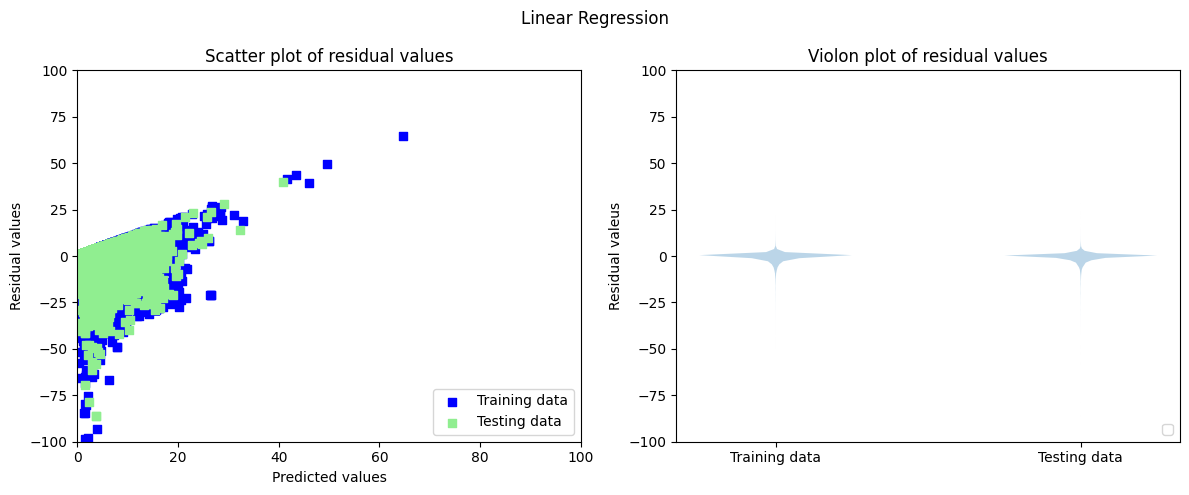

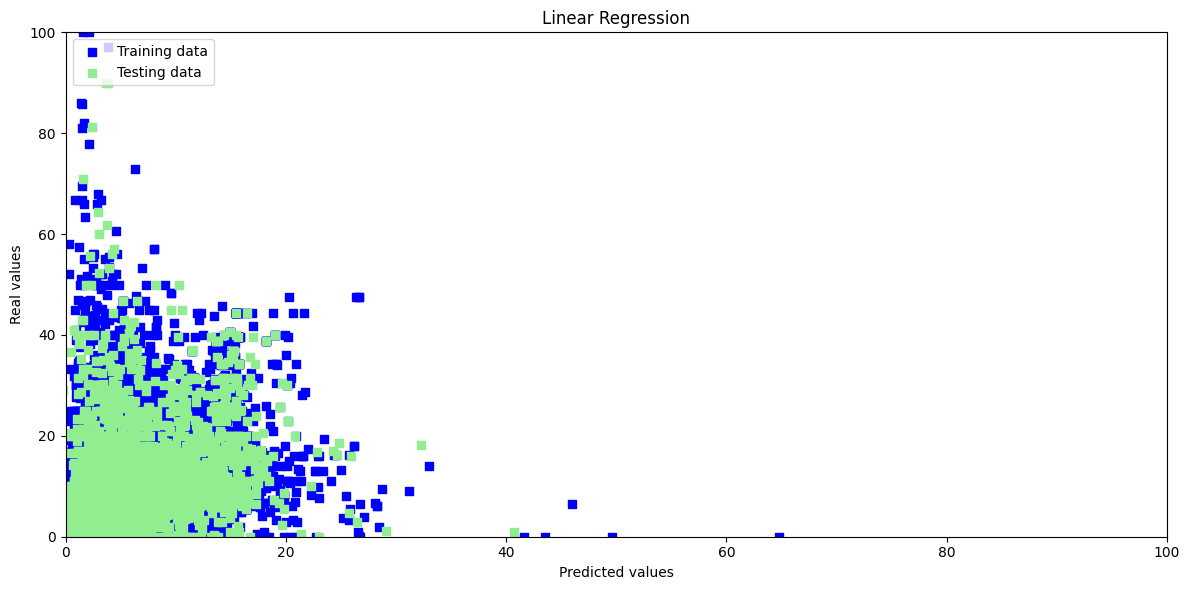

In [281]:
from sklearn.linear_model import Ridge

model = TransformedTargetRegressor(regressor = Ridge(), 
                                   func=np.log1p, 
                                   inverse_func=np.expm1)

parameters = {'transformation__scaler' : [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()],
             }

search_best_model("Linear Regression", model, categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

4 hyperparameters are tested
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=6.128 total time=   0.9s
[CV 2/5] END transformation__scaler=StandardScaler();, score=5.341 total time=   0.8s
[CV 3/5] END transformation__scaler=StandardScaler();, score=6.080 total time=   0.9s
[CV 4/5] END transformation__scaler=StandardScaler();, score=4.590 total time=   0.9s
[CV 5/5] END transformation__scaler=StandardScaler();, score=3.751 total time=   0.9s
[CV 1/5] END transformation__scaler=MinMaxScaler();, score=1.522 total time=   0.7s
[CV 2/5] END transformation__scaler=MinMaxScaler();, score=0.634 total time=   0.7s
[CV 3/5] END transformation__scaler=MinMaxScaler();, score=1.568 total time=   0.7s
[CV 4/5] END transformation__scaler=MinMaxScaler();, score=-0.157 total time=   0.8s
[CV 5/5] END transformation__scaler=MinMaxScaler();, score=-0.721 total time=   0.7s
[CV 1/5] END transformation__scaler=MaxAbsScaler();, score=

C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.230e+05, tolerance: 2.869e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END transformation__scaler=RobustScaler();, score=1.889 total time=  16.8s
[CV 2/5] END transformation__scaler=RobustScaler();, score=0.933 total time=   1.5s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.585e+05, tolerance: 2.855e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END transformation__scaler=RobustScaler();, score=1.914 total time=  17.0s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.354e+05, tolerance: 2.841e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END transformation__scaler=RobustScaler();, score=0.155 total time=  16.7s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+04, tolerance: 2.792e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END transformation__scaler=RobustScaler();, score=-0.395 total time=  16.7s
Mean score: 5.18 with an STD:  0.91 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


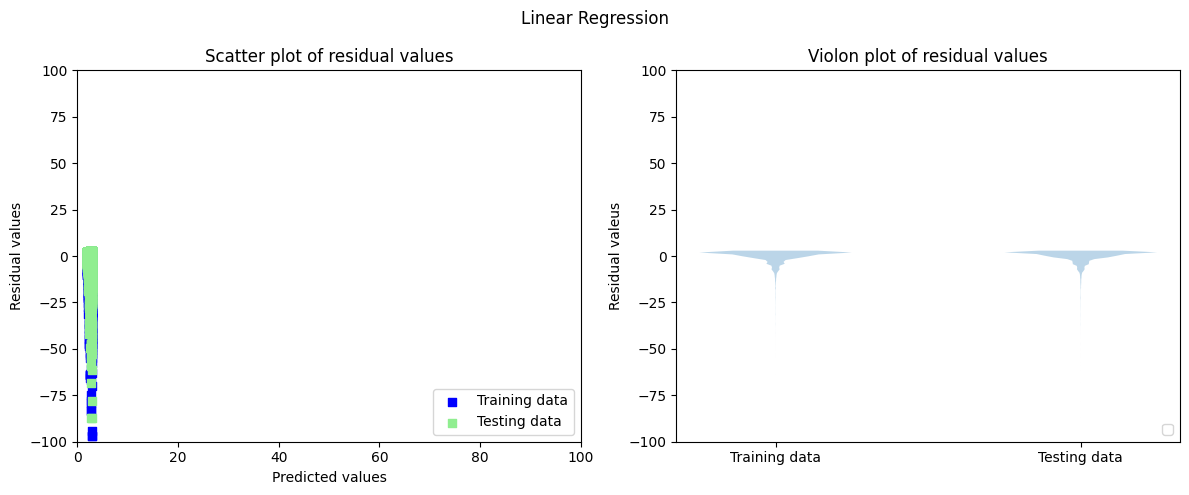

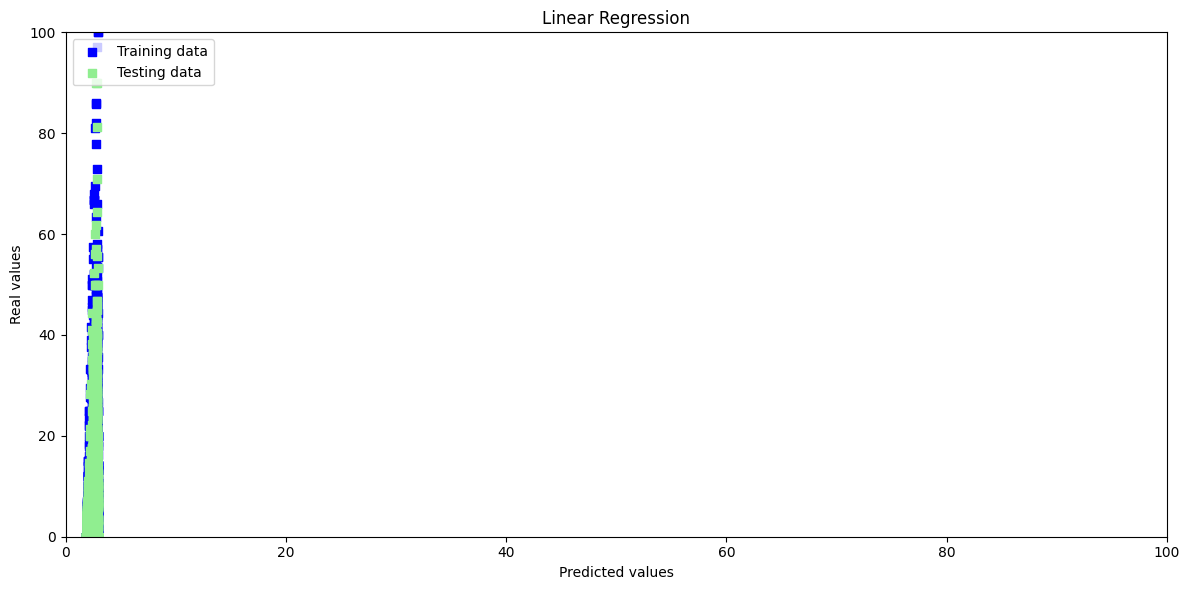

In [278]:
from sklearn.linear_model import Lasso

lr = Lasso()

parameters = {'transformation__scaler' : [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()],
             }

search_best_model("Linear Regression", lr, categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

In [279]:
from sklearn.linear_model import ElasticNet

lr = ElasticNet()

parameters = {'transformation__scaler' : [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()],
             }

search_best_model("Linear Regression", lr, categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

4 hyperparameters are tested
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=15.841 total time=   0.9s
[CV 2/5] END transformation__scaler=StandardScaler();, score=15.199 total time=   0.9s
[CV 3/5] END transformation__scaler=StandardScaler();, score=15.853 total time=   0.9s
[CV 4/5] END transformation__scaler=StandardScaler();, score=14.517 total time=   0.9s
[CV 5/5] END transformation__scaler=StandardScaler();, score=13.635 total time=   0.9s
[CV 1/5] END transformation__scaler=MinMaxScaler();, score=1.522 total time=   0.7s
[CV 2/5] END transformation__scaler=MinMaxScaler();, score=0.634 total time=   0.8s
[CV 3/5] END transformation__scaler=MinMaxScaler();, score=1.568 total time=   0.7s
[CV 4/5] END transformation__scaler=MinMaxScaler();, score=-0.157 total time=   0.7s
[CV 5/5] END transformation__scaler=MinMaxScaler();, score=-0.721 total time=   0.8s
[CV 1/5] END transformation__scaler=MaxAbsScaler();, s

C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+06, tolerance: 2.869e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END transformation__scaler=RobustScaler();, score=5.041 total time=  19.3s
[CV 2/5] END transformation__scaler=RobustScaler();, score=3.780 total time=   1.8s


C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+06, tolerance: 2.855e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END transformation__scaler=RobustScaler();, score=5.026 total time=  19.8s


KeyboardInterrupt: 

4 hyperparameters are tested
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=-2124.484 total time=   1.0s
[CV 2/5] END transformation__scaler=StandardScaler();, score=246.852 total time=   1.0s
[CV 3/5] END transformation__scaler=StandardScaler();, score=967.695 total time=   1.0s
[CV 4/5] END transformation__scaler=StandardScaler();, score=1258.192 total time=   1.0s
[CV 5/5] END transformation__scaler=StandardScaler();, score=-296.177 total time=   1.0s
[CV 1/5] END transformation__scaler=MinMaxScaler();, score=36.092 total time=   2.3s
[CV 2/5] END transformation__scaler=MinMaxScaler();, score=33.351 total time=   2.6s
[CV 3/5] END transformation__scaler=MinMaxScaler();, score=36.350 total time=   2.6s
[CV 4/5] END transformation__scaler=MinMaxScaler();, score=35.042 total time=   2.5s
[CV 5/5] END transformation__scaler=MinMaxScaler();, score=33.718 total time=   2.7s
[CV 1/5] END transformation__scaler=MaxAbs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


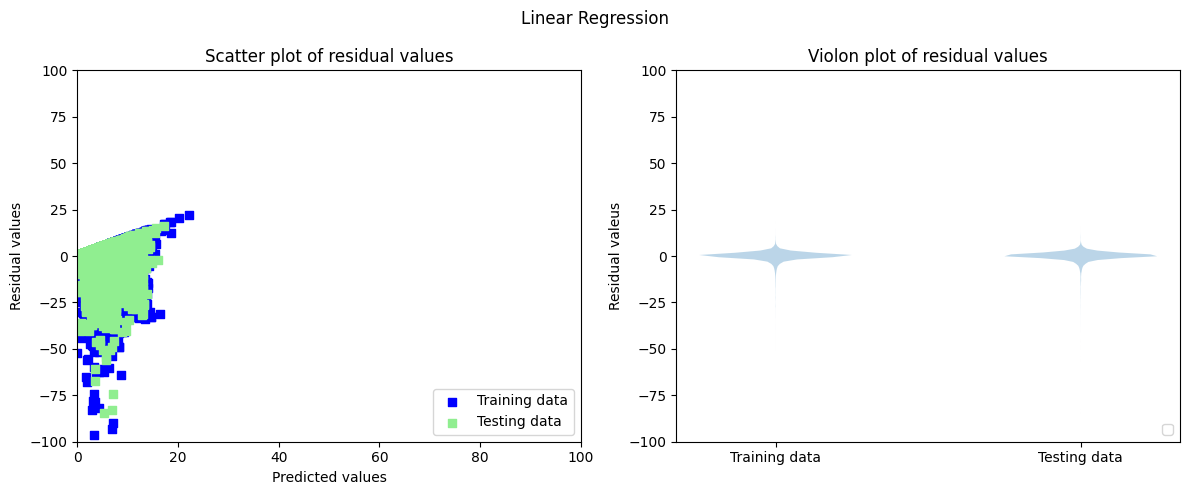

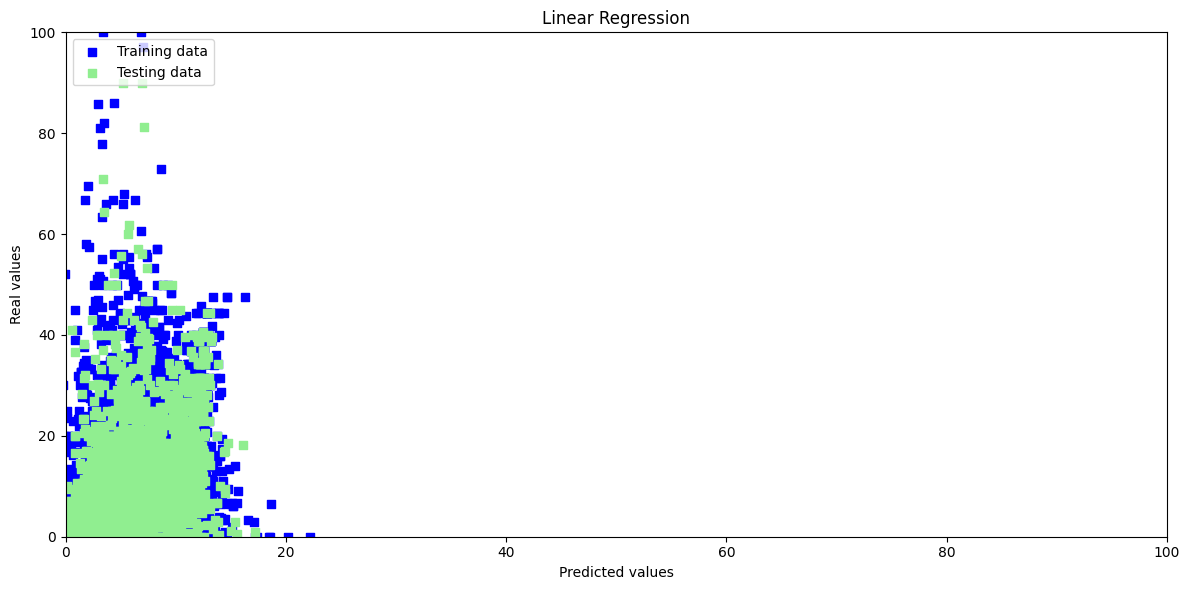

In [310]:
from sklearn.linear_model import SGDRegressor

model = TransformedTargetRegressor(regressor = SGDRegressor(), 
                                   func=np.log1p, 
                                   inverse_func=np.expm1)

parameters = {'transformation__scaler' : [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()],
             }

search_best_model("Linear Regression", SGDRegressor(), categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

In [312]:
from sklearn import kernel_ridge

model = TransformedTargetRegressor(regressor = kernel_ridge.KernelRidge(), 
                                   func=np.log1p, 
                                   inverse_func=np.expm1)


parameters = {'transformation__scaler' : [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()],
             }

search_best_model("Linear Regression", model, categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

4 hyperparameters are tested
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END transformation__scaler=StandardScaler();, score=nan total time=   0.4s
[CV 2/5] END transformation__scaler=StandardScaler();, score=nan total time=   0.4s
[CV 3/5] END transformation__scaler=StandardScaler();, score=nan total time=   0.4s
[CV 4/5] END transformation__scaler=StandardScaler();, score=nan total time=   0.4s
[CV 5/5] END transformation__scaler=StandardScaler();, score=nan total time=   0.4s
[CV 1/5] END transformation__scaler=MinMaxScaler();, score=nan total time=   0.4s
[CV 2/5] END transformation__scaler=MinMaxScaler();, score=nan total time=   0.3s
[CV 3/5] END transformation__scaler=MinMaxScaler();, score=nan total time=   0.4s
[CV 4/5] END transformation__scaler=MinMaxScaler();, score=nan total time=   0.4s
[CV 5/5] END transformation__scaler=MinMaxScaler();, score=nan total time=   0.4s
[CV 1/5] END transformation__scaler=MaxAbsScaler();, score=nan total time=   0.4s

ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\compose\_target.py", line 267, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\kernel_ridge.py", line 201, in fit
    K = self._get_kernel(X)
        ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\kernel_ridge.py", line 168, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\metrics\pairwise.py", line 2366, in pairwise_kernels
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\metrics\pairwise.py", line 1766, in _parallel_pairwise
    return func(X, Y, **kwds)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\utils\_param_validation.py", line 187, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\metrics\pairwise.py", line 1330, in linear_kernel
    return safe_sparse_dot(X, Y.T, dense_output=dense_output)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\utils\extmath.py", line 192, in safe_sparse_dot
    ret = a @ b
          ~~^~~
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 300. GiB for an array with shape (200779, 200779) and data type float64

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\compose\_target.py", line 267, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\kernel_ridge.py", line 201, in fit
    K = self._get_kernel(X)
        ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\kernel_ridge.py", line 168, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\metrics\pairwise.py", line 2366, in pairwise_kernels
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\metrics\pairwise.py", line 1766, in _parallel_pairwise
    return func(X, Y, **kwds)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\utils\_param_validation.py", line 187, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\metrics\pairwise.py", line 1330, in linear_kernel
    return safe_sparse_dot(X, Y.T, dense_output=dense_output)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\Desktop\Data scientist formation\[Projets]\Projet NutritionApp\env\Lib\site-packages\sklearn\utils\extmath.py", line 192, in safe_sparse_dot
    ret = a @ b
          ~~^~~
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 300. GiB for an array with shape (200780, 200780) and data type float64


In [316]:
from sklearn.ensemble import RandomForestRegressor

model = TransformedTargetRegressor(regressor = RandomForestRegressor(), 
                                   func=np.log1p, 
                                   inverse_func=np.expm1)

# On test différents scaler et d'autres hyperparamètres
parameters = {'transformation__scaler' : [None, StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler(), RobustScaler()]
             }
search_best_model("Linear Regression", RandomForestRegressor(), categorical_feature, numeric_features_to_fibers, parameters, xtrain, ytrain, xtest, ytest)

6 hyperparameters are tested
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........transformation__scaler=None;, score=nan total time=   0.0s
[CV 2/5] END .........transformation__scaler=None;, score=nan total time=   0.0s
[CV 3/5] END .........transformation__scaler=None;, score=nan total time=   0.0s
[CV 4/5] END .........transformation__scaler=None;, score=nan total time=   0.0s
[CV 5/5] END .........transformation__scaler=None;, score=nan total time=   0.0s


KeyboardInterrupt: 

### <a name = "T4C5">e. Results</a>

In [ ]:
stop

In [ ]:
mlflow.set_experiment("FINAL_VERSION_Developpement_dun_modele_de_bank_scoring")
# On ajoute en plus du nom du classifier
name = "DummyClassifier"
# On enregistre le modèle et le seuil
save_model(model, save_model_name)
# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run: